# Image Shift v1

Fix left image and shift the right image horizontally and vertically until the Euclidian distance minizes.
1. Shift range x: (-5, 5)
2. Shift range y: (-5, 5)

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import os
import gc

2022-09-27 19:13:07.764158: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-27 19:13:07.927547: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-27 19:13:07.927571: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-27 19:13:07.965474: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-27 19:13:08.737062: W tensorflow/stream_executor/pla

In [2]:
SEED = 42
PATH = './input/' # path to public.csv
TRAIN_PATH = './input/train/train/' # path to train images
TEST_PATH = './input/test/test/' # path to test images
TARGETS = ['North', 'East']
VECS_GENERATED = True
np.random.seed(SEED)

# Data

In [3]:
df = pd.read_csv(os.path.join(PATH, 'public.csv'))
train = df[df['North'].notna()]
test = df[df['North'].isna()]
train.shape, test.shape

((91231, 5), (55031, 5))

# Utils

In [6]:
def shift_and_cut_img(img, value, axis):
    """Apply the numpy rolling function at each channel and cut the image"""
    new_img = np.empty(img.shape)
    for channel in range(3):
        new_img[:,:,channel] = np.roll(img[:,:,channel], value, axis)
    return cut_img(new_img, value)

def cut_img(img, vec):
    """Cut the image with shape (n, m, k) by the given vector (x, y)
    if x positive start from column x to m
    if x negative start from column 0 to m-x
    if y positive start from row y to n
    se x negative start from row 0 to n-y"""
    x, y = vec
    n, m, k = img.shape
    if x > 0:
        col_start = x
        col_end = m
    else:
        col_start = 0
        col_end = m+x

    if y > 0:
        row_start = y
        row_end = n
    else:
        row_start = 0
        row_end = n+y
    return img[row_start:row_end, col_start:col_end, :]

def compute_dist(a, b):
    """Flatten images and compute the euclidian distance between vectors"""
    a = np.array([a[:,:,channel].flatten() for channel in range(3)])
    b = np.array([b[:,:,channel].flatten() for channel in range(3)])    
    return np.linalg.norm(b - a)

def load_and_split_img(file, is_train=True):
    """Load a given sample image and split in left and right image"""
    img_path = TRAIN_PATH + "/" + file if is_train else TEST_PATH + "/" + file
    img = img_to_array(load_img(img_path))
    left = img[:, :120, :]
    right = img[:, 120:, :]
    return left, right

def find_best_vec(left, right, x_range=5, y_range=5):
    """Iterate in the given search space seeking for the vector that minimize
    the euclidian distance between left and right images"""
    best_vec = (0,0)
    best_dist = 999_999
    for x in range(-5, 5, 1):
        for y in range(-5, 5, 1):
            vec = (x, y)
            right_shift = shift_and_cut_img(right, vec, (1,0))
            left_cut = cut_img(left, vec)
            vec_dist = compute_dist(left_cut, right_shift)
            if vec_dist < best_dist:
                best_vec = vec
                best_dist = vec_dist
    return best_vec[0], best_vec[1], best_dist

# Plotting Examples

North   -0.386045
East     0.929772
Name: 0, dtype: float64


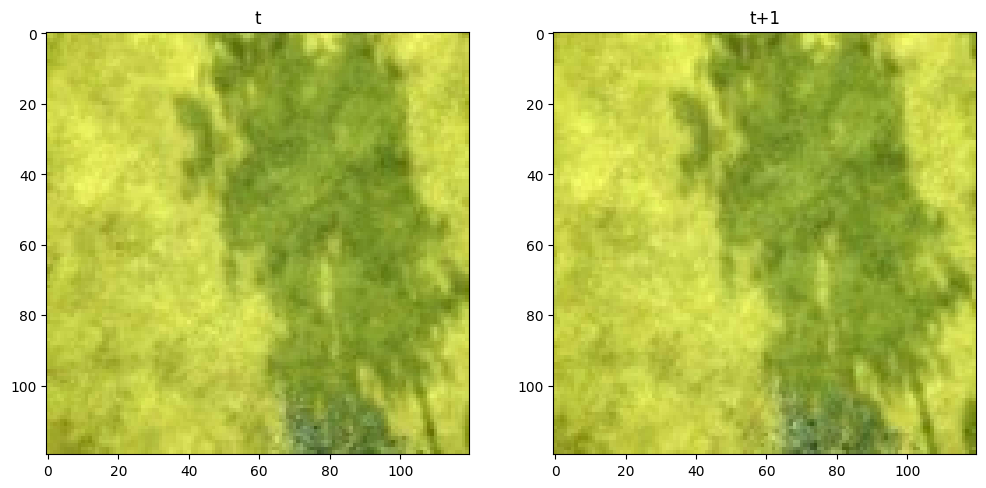

Original: 1975.364990234375
(-1, 3): 614.7121277476149


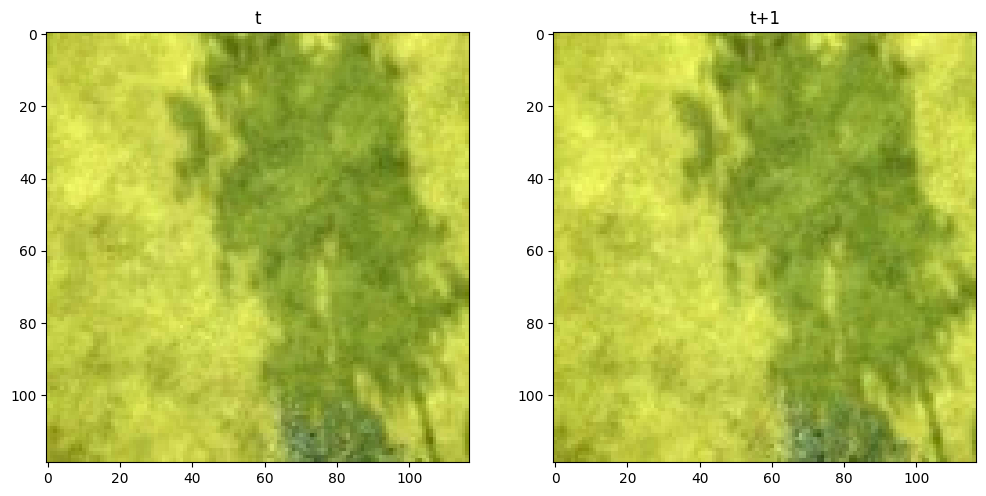

North    0.635584
East     0.152819
Name: 1, dtype: float64


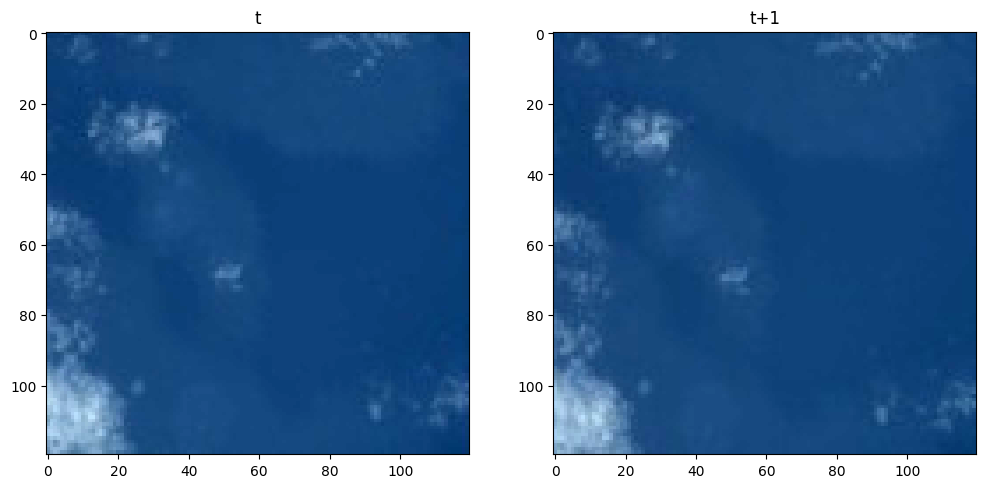

Original: 505.68963623046875
(1, 0): 289.89135896055956


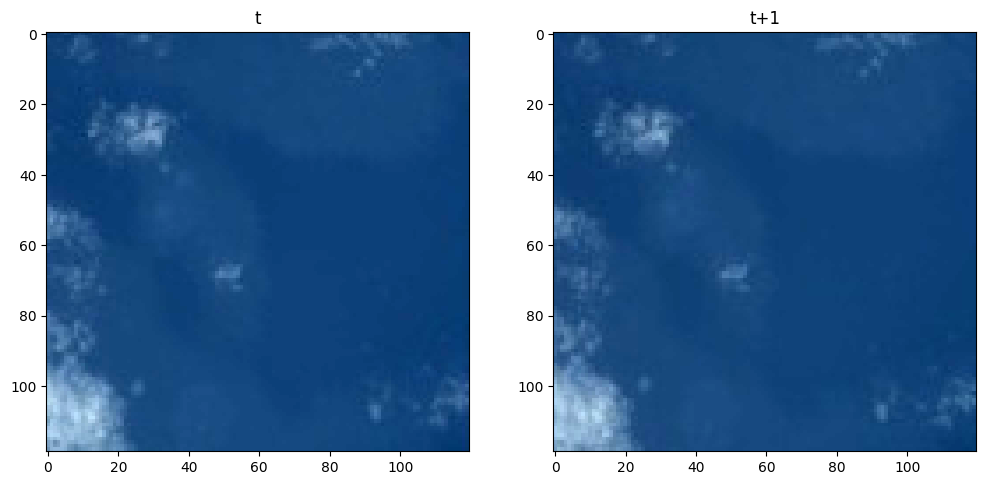

North   -1.228229
East    -0.499388
Name: 2, dtype: float64


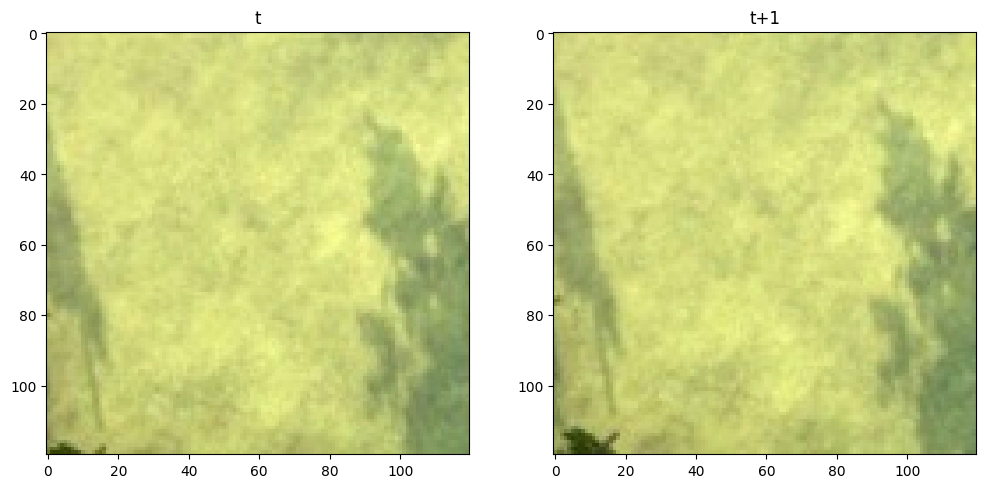

Original: 1759.7607421875
(-4, -2): 542.0590373750815


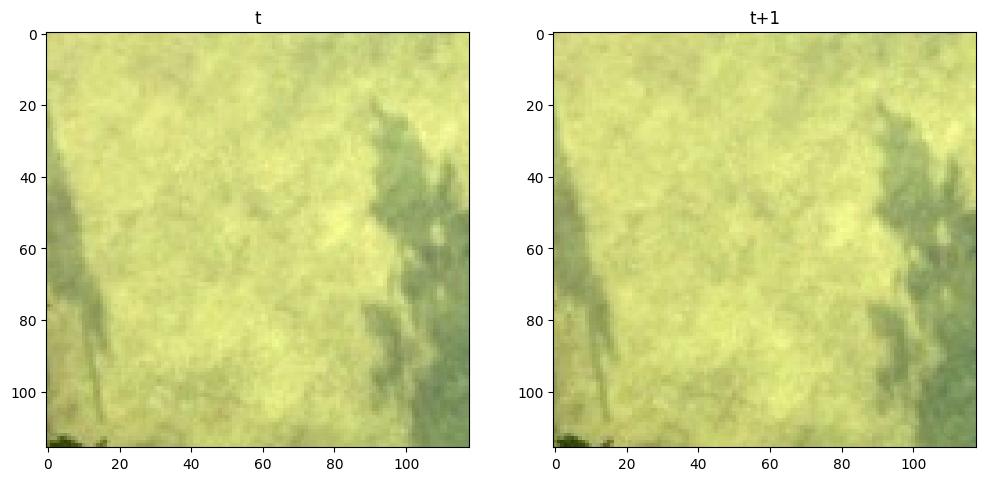

North   -1.739709
East    -0.699928
Name: 3, dtype: float64


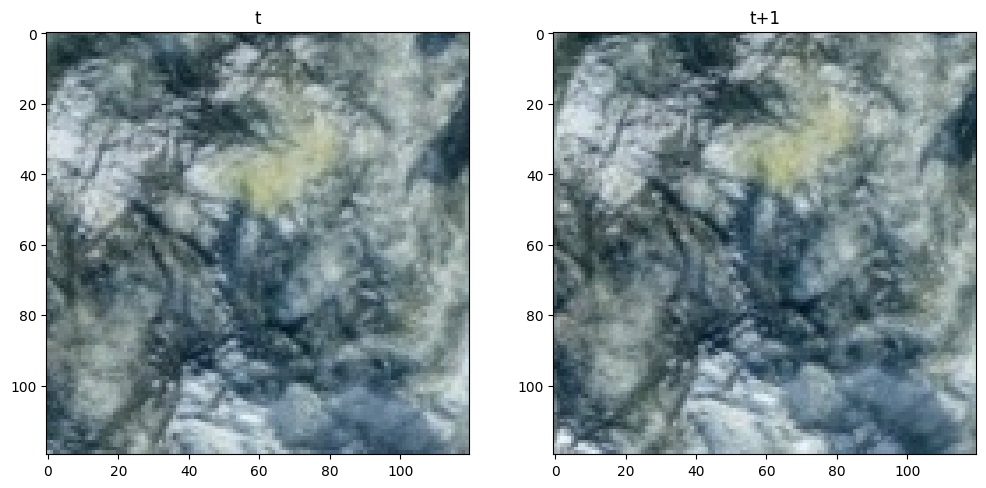

Original: 7349.77294921875
(-4, -2): 4836.504626277122


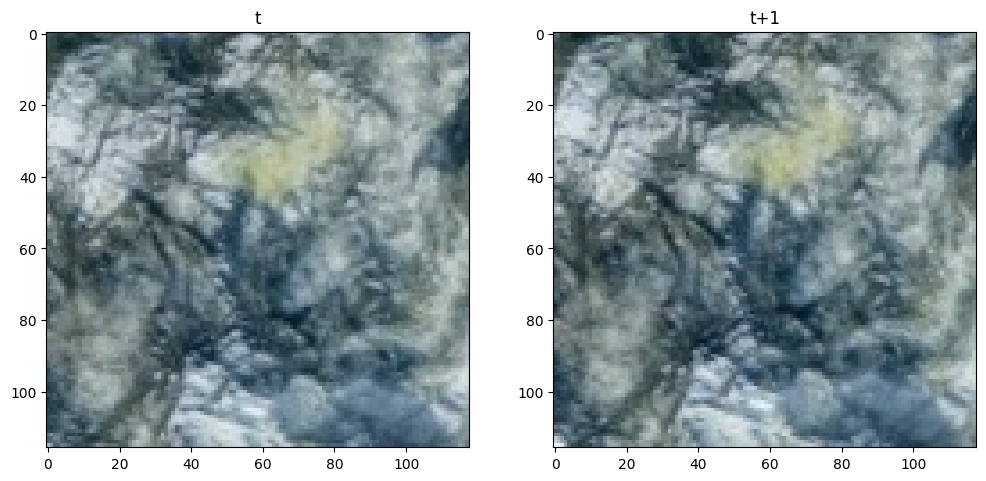

North   -0.169798
East     2.828752
Name: 4, dtype: float64


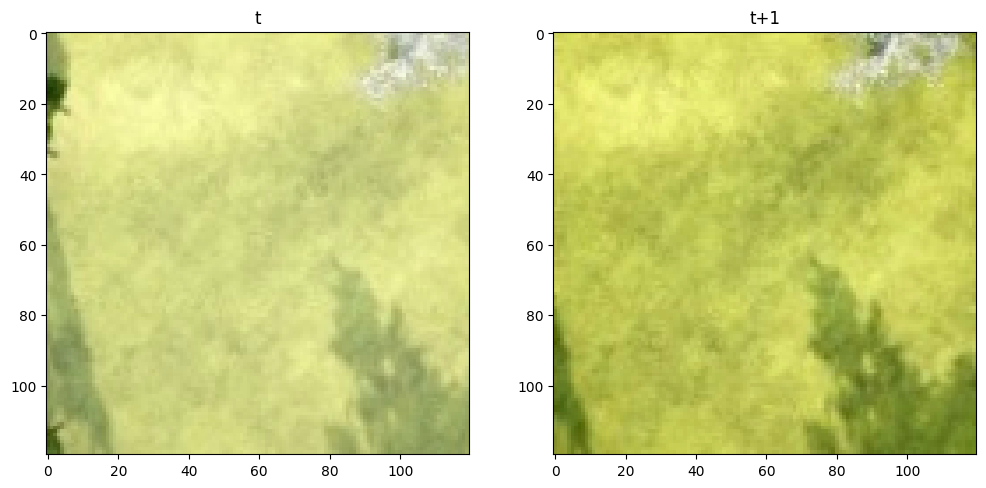

Original: 3384.74658203125
(1, 4): 2213.0065521818956


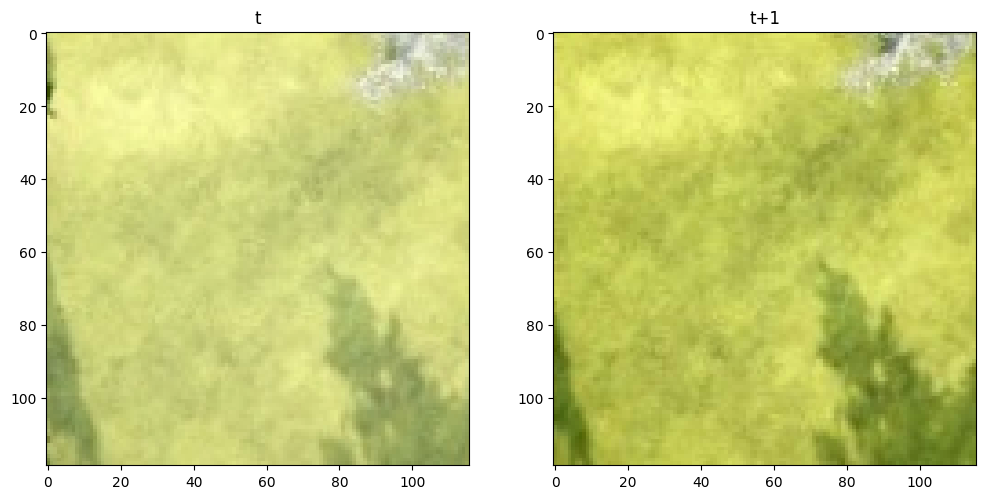

North   -0.321776
East    -0.075522
Name: 5, dtype: float64


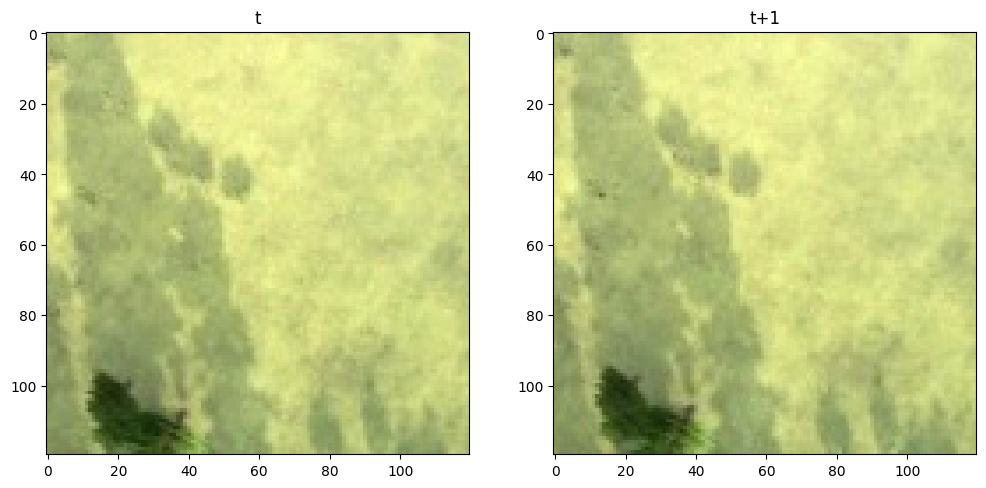

Original: 1136.998291015625
(-1, 0): 668.3472151509274


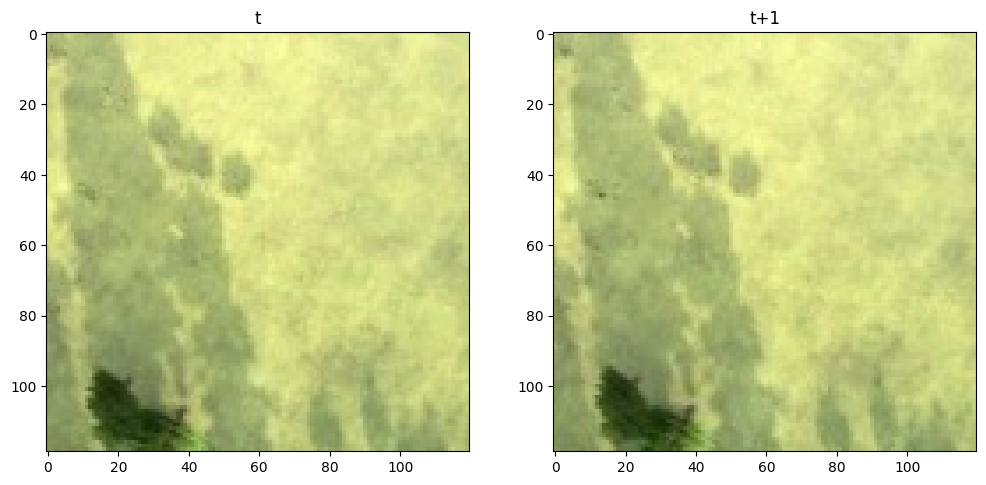

North    0.646206
East    -1.686776
Name: 6, dtype: float64


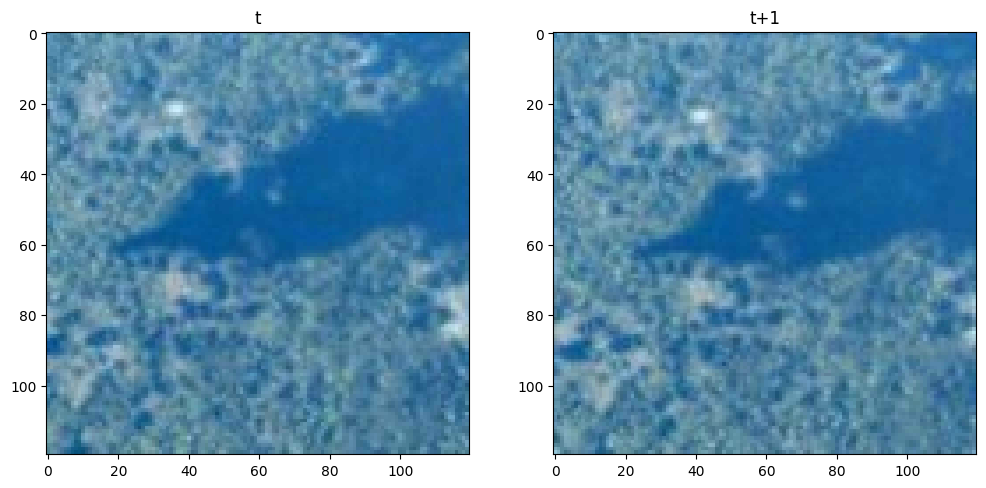

Original: 1921.892822265625
(2, -5): 628.1273756173981


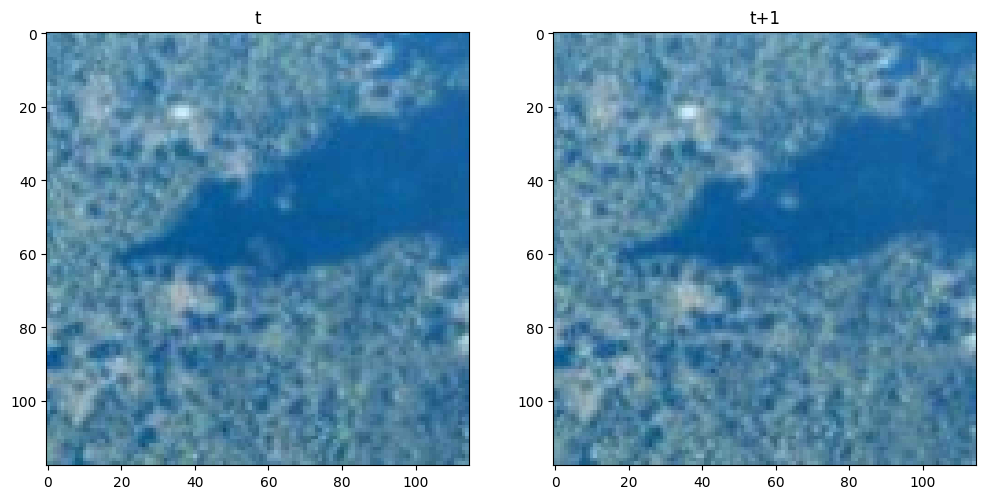

North   -0.178107
East     0.132653
Name: 7, dtype: float64


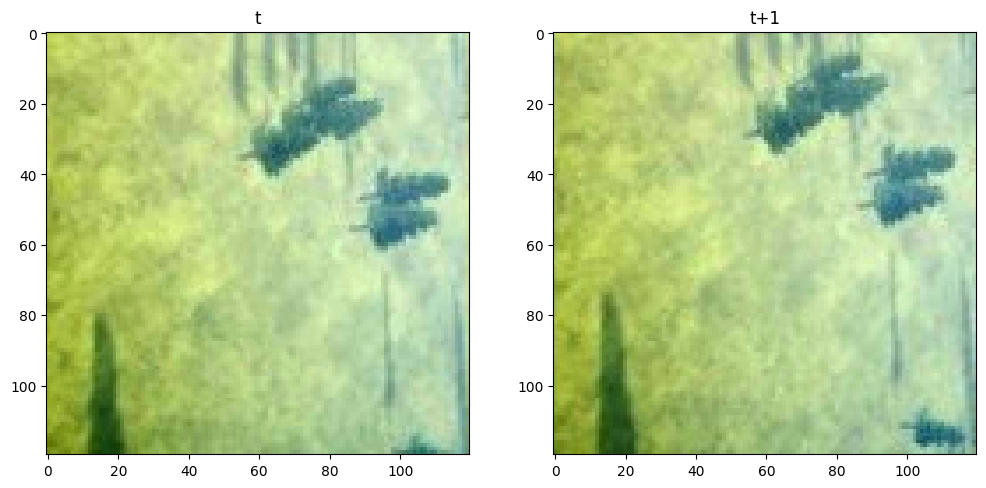

Original: 1799.00390625
(-4, 0): 1185.1215127572361


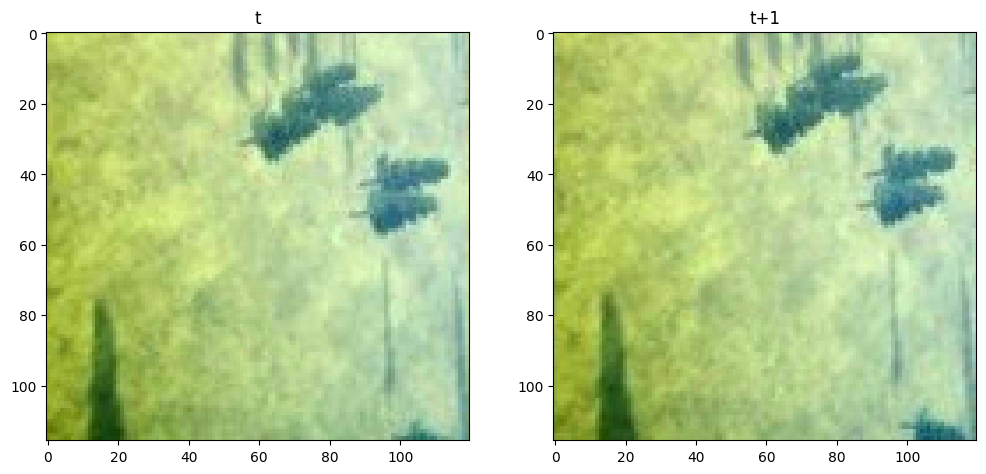

North   -1.825883
East     1.956080
Name: 8, dtype: float64


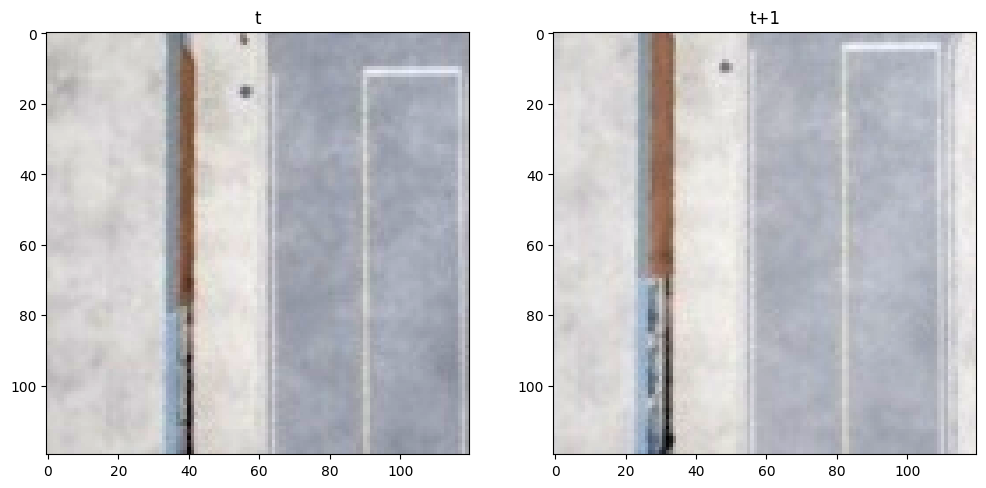

Original: 4903.15185546875
(-4, 4): 3717.841309147016


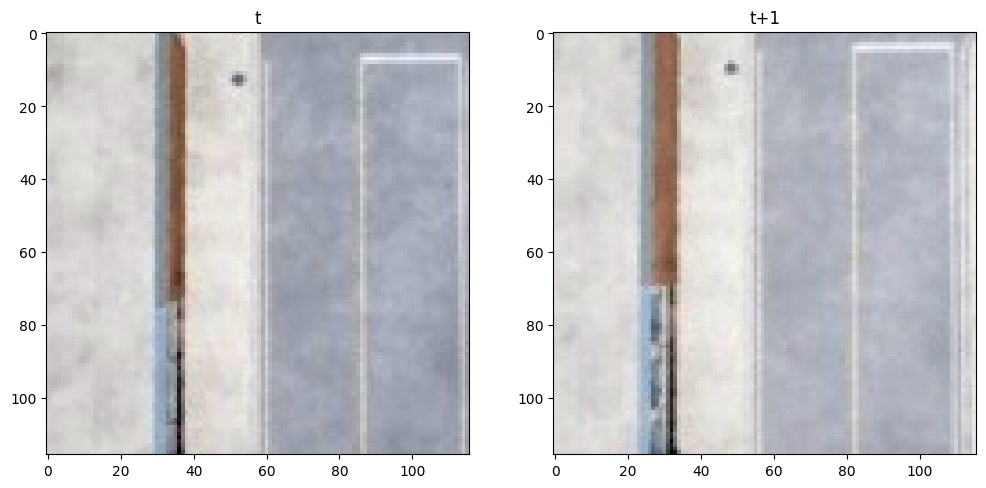

North    2.465519
East    -0.883750
Name: 9, dtype: float64


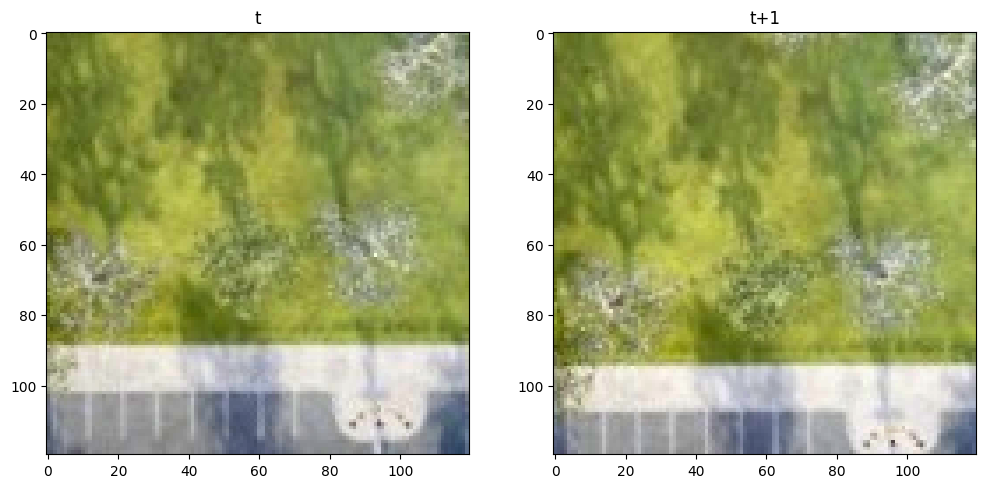

Original: 2985.787841796875
(5, -2): 1244.2266674525185


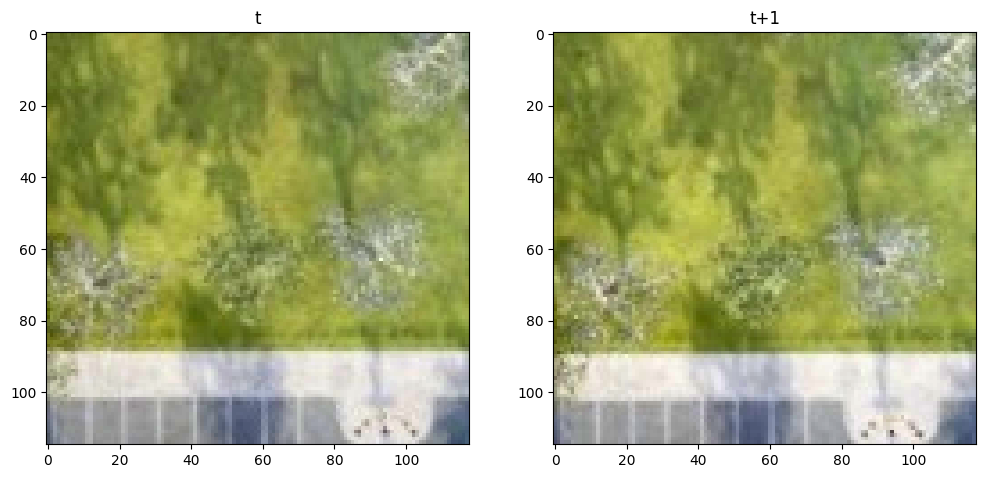

In [7]:
for i, file in enumerate(train['Filename'].values[:10]):
    print(train[TARGETS].iloc[i])
    
    left, right = load_and_split_img(file)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(array_to_img(left))
    axs[0].set_title('t')
    axs[1].imshow(array_to_img(right))
    axs[1].set_title('t+1')
    plt.show()
    
    best_vec = (0,0)
    best_dist = 999_999
    
    print(f'Original: {compute_dist(left, right)}')    
    
    x, y, best_dist = find_best_vec(left, right)
    best_vec = x, y
    print(f'{-y, x}: {best_dist}')
    
    right_shift = shift_and_cut_img(right, best_vec, (1,0))
    left_cut = cut_img(left, best_vec)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))    
    axs[0].imshow(array_to_img(left_cut))
    axs[0].set_title('t')
    axs[1].imshow(array_to_img(right_shift))
    axs[1].set_title('t+1')
    plt.show()
    
    print('='*50)

# Process train images

In [8]:
def pipeline(file, is_train=True):
    left, right = load_and_split_img(file, is_train)
    x, y, best_dist = find_best_vec(left, right)
    dist = compute_dist(left, right)
    return file, -y, x, best_dist, dist

In [11]:
%%time
import multiprocessing as mp
with mp.Pool(mp.cpu_count()) as pool:
    result = pool.map(pipeline, train['Filename'])

CPU times: user 582 ms, sys: 214 ms, total: 796 ms
Wall time: 1h 28min 52s


In [12]:
df_vec = pd.DataFrame(result, columns=['Filename', 'x', 'y', 'best_dist', 'dist'])
df_vec

,Filename,x,y,best_dist,dist
0,00003e3b9e5336685200ae85d21b4f5e.jpg,-1,3,614.712128,1975.364990
1,0001261e2060303a06ba6c64d676d639.jpg,1,0,289.891359,505.689636
2,0002ac0d783338cfeab0b2bdbd872cda.jpg,-4,-2,542.059037,1759.760742
3,0004289ee1c7b8b08c77e19878106ae3.jpg,-4,-2,4836.504626,7349.772949
4,0004d0b59e19461ff126e3a08a814c33.jpg,1,4,2213.006552,3384.746582
...,...,...,...,...,...
91226,fffe56994e6be696722539f962415cd2.jpg,5,-5,6131.121920,6559.501953
91227,fffe9f664c2ddba4a37bcd35936c7422.jpg,-4,-1,1070.417675,2345.493896
91228,fffee5badc626a2ab8086120712e5639.jpg,4,-5,1982.231571,2336.549805
91229,ffffda8ada4827900cbf65fd20281080.jpg,5,0,1497.974966,6159.958984


In [13]:
df_vec.to_csv('/home/azureuser/Dropbox/kddbr2022/input/train/train_vec_v1.csv', index=False)

# Process test images

In [14]:
def pipeline(file, is_train=False):
    left, right = load_and_split_img(file, is_train)
    x, y, best_dist = find_best_vec(left, right)
    dist = compute_dist(left, right)
    return file, -y, x, best_dist, dist

In [15]:
%%time
import multiprocessing as mp
with mp.Pool(mp.cpu_count()) as pool:
    result = pool.map(pipeline, test['Filename'])

CPU times: user 527 ms, sys: 191 ms, total: 718 ms
Wall time: 53min 27s


In [16]:
df_vec_test = pd.DataFrame(result, columns=['Filename', 'x', 'y', 'best_dist', 'dist'])
df_vec_test

,Filename,x,y,best_dist,dist
0,000053b1e684c9e7ea73727b2238ce18.jpg,-1,-1,8459.940662,8505.025391
1,00029153d12ae1c9abe59c17ff2e0895.jpg,3,-4,4142.474623,7071.733398
2,0006246bee639c7a7b11a08e34dd3cc6.jpg,-4,-2,3888.212571,4170.063477
3,00063cb5da1826febf178b669eea3250.jpg,-4,4,1998.686319,2402.529541
4,00063ece2e68a8847f228e8fd922f851.jpg,0,-5,1466.539805,3254.245117
...,...,...,...,...,...
55026,fff87fc38496c1838a216c742e653065.jpg,5,4,1335.803129,1717.837891
55027,fff98e721ed96517d940eb5b2daf2d18.jpg,-1,4,2348.343672,2700.197754
55028,fff9e3be29d11366c43df7b2ae749547.jpg,3,3,590.409180,2374.966064
55029,fffae68750a8bd5e6ba46b25ce7030de.jpg,-3,-5,2544.289488,5234.365723


In [17]:
df_vec_test.to_csv('/home/azureuser/Dropbox/kddbr2022/input/test/test_vec_v1.csv', index=False)

# Next Steps

1. Apply filters
2. Change distance metrics